In [1]:
from os import environ

from jax import random, vmap
import jax.numpy as np
from optax import adam, cosine_decay_schedule
from jaxopt import OptaxSolver

from pinns.ivps import advection
from pinns.nn import Siren

environ["CUDA_VISIBLE_DEVICES"] = "2"

GPU : TITAN RTX

Basic Siren PINN.

In [2]:
class pinn(advection):
    def __init__(self, width=64, depth=5, w0=8.):
        super().__init__()
        layers = [2] + [width for _ in range(depth-1)] + [1]
        self.init, self.apply = Siren(layers, w0)
        self.u = vmap(vmap(self._u, 
                           (None, 0,None), 0),
                           (None, None,0), 1) # (Nt, Nx)

    def _u(self, params, t,x): # scalar function
        inputs = np.hstack([t,x])
        output = self.apply(params, inputs).squeeze()
        return output

In [3]:
model_pinn = pinn()
init_key, train_key = random.split(random.PRNGKey(0))
init_params = model_pinn.init(init_key)

nIter = 1*10**5
lr = cosine_decay_schedule(1e-03, nIter)
optimizer = OptaxSolver(fun=model_pinn.loss, opt=adam(lr))

Nt, Nx = 128, 128
domain_tr = (model_pinn.T * np.linspace(0,1, Nt),
             model_pinn.X * np.linspace(*model_pinn.x_bd, Nx))

u_t + βu_x = 0


100%|██████████| 100000/100000 [05:13<00:00, 319.28it/s, pinn loss=2.540e-04]


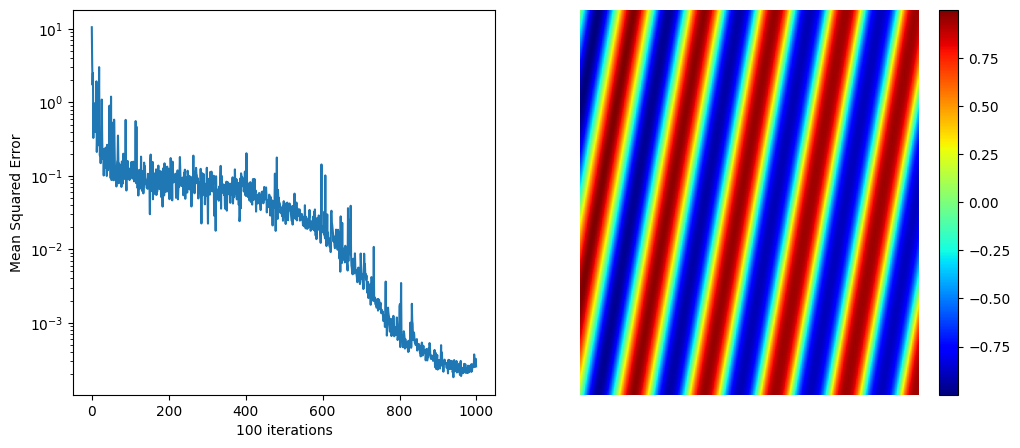

In [4]:
model_pinn.train(optimizer, domain_tr, train_key, init_params, nIter=nIter)
model_pinn.drawing(save=False)

Siren Separable PINN, to accelerate training.

In [5]:
class spinn(advection):
    def __init__(self, width=64, depth=4, d_out=64, w0=8.):
        super().__init__()
        layers = [1] + [width for _ in range(depth-1)] + [d_out]
        self.init, self.apply = Siren(layers, w0)

    def u(self, params, t,x): # (Nt, Nx)
        t, x = t.reshape(-1,1), x.reshape(-1,1)
        outputs = self.apply(params[0], t) @ self.apply(params[1], x).T
        return outputs

u_t + βu_x = 0


  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [02:01<00:00, 820.89it/s, pinn loss=2.357e-05]


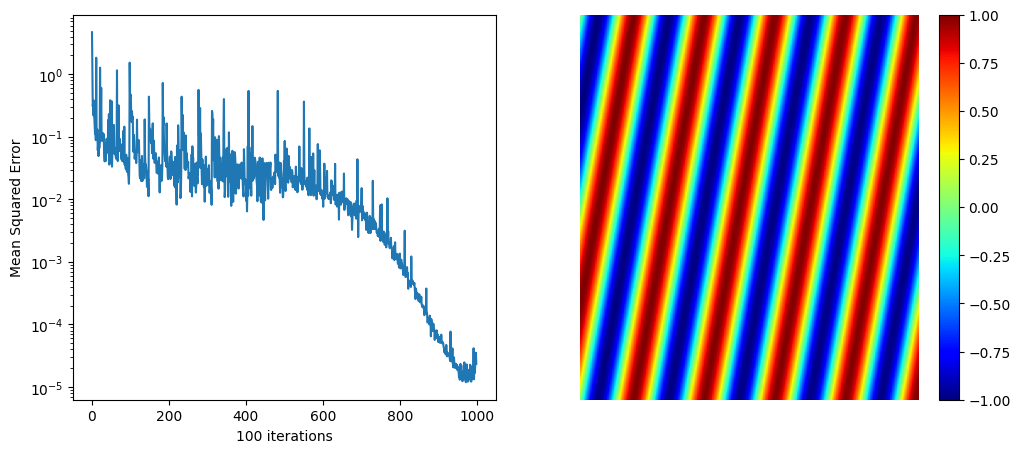

In [6]:
model_spinn = spinn()
*init_keys, train_key = random.split(random.PRNGKey(0), 3)
init_params = [model_spinn.init(_key) for _key in init_keys]

optimizer = OptaxSolver(fun=model_spinn.loss, opt=adam(lr))

model_spinn.train(optimizer, domain_tr, train_key, init_params, nIter=nIter)
model_spinn.drawing(save=False)